In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# AI Platform (Unified) SDK: Custom image classification model for online prediction with explainability

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-platform-samples/master/notebooks/deepdive/custom/ucaip_customjob_image_explain.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-platform-samples/master/notebooks/deepdive/custom/ucaip_customjob_image_explain.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

# Overview


This tutorial demonstrates how to use the AI Platform (Unified) Python SDK to train and deploy a custom image classification model for online prediction with explainability.

### Dataset

The dataset used for this tutorial is the [cifar10 dataset](https://www.tensorflow.org/datasets/catalog/cifar10) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). The version of the dataset you will use is built into Tensorflow. The trained model predicts which type of class an image is from ten classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

### Objective

In this notebook, you will learn how to create a custom model from a Python script in a docker container using the AI Platform (Unified) SDK, and then do a prediction with explainability on the deployed model. You can alternatively create custom models from the command line using `gcloud` or online using Google Cloud Console.

The steps performed include: 

- Create an AI Platform (Unified) custom job for training a model.
- Train the model.
- Retrieve and load the model (artifacts).
- View the model evaluation.
- Upload the model as a AI Platform (Unified) model for explainability.
- Deploy the model to a serving endpoint.
- Make a prediction with explanations.
- Undeploy the model.

### Costs 

This tutorial uses billable components of Google Cloud Platform (GCP):

* Cloud AI Platform
* Cloud Storage

Learn about [Cloud AI Platform
pricing](https://cloud.google.com/ml-engine/docs/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the latest (version) version of AI Platform (Unified) SDK.

In [ ]:
! pip3 install -U google-cloud-aiplatform --user

Install the Google `cloud-storage` library as well.

In [ ]:
! pip3 install google-cloud-storage

Install openCV, which will be used for creating test images.

In [ ]:
! pip install opencv-python

### Restart the Kernel

Once you've installed the AI Platform (Unified) SDK, you need to restart the notebook kernel so it can find the packages.

In [ ]:
import os
if not os.getenv("AUTORUN"):
    # Automatically restart kernel after installs
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### GPU run-time

**Make sure you're running this notebook in a GPU runtime if you have that option. In Colab, select Runtime > Change runtime type > GPU**

### Set up your GCP project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform APIs, Compute Engine APIs and Container Registry API.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component,containerregistry.googleapis.com)

4. [Google Cloud SDK](https://cloud.google.com/sdk) is already installed in AI Platform Notebooks.

5. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Project ID

**If you don't know your project ID**, you might be able to get your project ID using `gcloud` command by executing the second cell below.

In [1]:
PROJECT_ID = "jk-mlops-dev" #@param {type:"string"}

In [2]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

In [3]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for AI Platform (Unified). We recommend when possible, to choose the region closest to you. 

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You can not use a Multi-Regional Storage bucket for training with AI Platform. Not all regions provide support for all AI Platform services. For the lastest support per region, see [Region support for AI Platform (Unified) services](https://cloud.google.com/ai-platform-unified/docs/general/locations)

In [4]:
REGION = 'us-central1' #@param {type: "string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append onto the name of resources which will be created in this tutorial.

In [5]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your GCP account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

In [6]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your Google Cloud account. This provides access
# to your Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# If on AI Platform, then don't execute this code
if not os.path.exists('/opt/deeplearning/metadata/env_version'):
    if 'google.colab' in sys.modules:
        from google.colab import auth as google_auth
        google_auth.authenticate_user()

    # If you are running this tutorial in a notebook locally, replace the string
    # below with the path to your service account key and run this cell to
    # authenticate your Google Cloud account.
    else:
        %env GOOGLE_APPLICATION_CREDENTIALS your_path_to_credentials.json

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a custom training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. AI Platform runs
the code from this package. In this tutorial, AI Platform also saves the
trained model that results from your job in the same bucket. You can then
create an AI Platform endpoint based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets. 

In [7]:
BUCKET_NAME = "jk-caip-demos" #@param {type:"string"}

In [8]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "ucaip-custom-" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [9]:
! gsutil mb -l $REGION gs://$BUCKET_NAME

Creating gs://jk-caip-demos/...


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [10]:
! gsutil ls -al gs://$BUCKET_NAME

### Import libraries and define constants

#### Import AI Platform (Unified) SDK

Import the AI Platform (Unified) SDK into your Python environment.

In [11]:
import os
import sys
import time
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

#from google.cloud.aiplatform import gapic as aip
import google.cloud.aiplatform_v1beta1 as aip

#### AI Platform (Unified) constants

Let's now setup some constants for AI Platform (Unified):

- `API_ENDPOINT`: The AI Platform (Unified) API service endpoint for dataset, model, job, pipeline and endpoint services.
- `API_PREDICT_ENDPOINT`: The AI Platform (Unified) API service endpoint for prediction.
- `PARENT`: The AI Platform (Unified) location root path for dataset, model and endpoint resources.

In [12]:
# API Endpoint
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
API_PREDICT_ENDPOINT = "{}-prediction-aiplatform.googleapis.com".format(REGION)

# AI Platform (Unified) location root path for your dataset, model and endpoint resources
PARENT = "projects/" + PROJECT_ID + "/locations/" + REGION

#### Hardware Accelerators

Let's now set the hardware accelerators (e.g., GPU), if any, for training and prediction.

Set the variables `TRAIN_GPU/TRAIN_NGPU` and `DEPLOY_GPU/DEPLOY_NGPU` to use a container image supporting a GPU and the number of GPUs allocated to the compute instance. For example, to use a GPU container image with 4 Nvidia Telsa K80 GPUs allocated to each compute instance, you would specify:

    (aip.AcceleratorType.NVIDIA_TESLA_K80, 4)

For GPU, available accelerators include:
   - aip.AcceleratorType.NVIDIA_TESLA_K80
   - aip.AcceleratorType.NVIDIA_TESLA_P100
   - aip.AcceleratorType.NVIDIA_TESLA_P4
   - aip.AcceleratorType.NVIDIA_TESLA_T4
   - aip.AcceleratorType.NVIDIA_TESLA_V100

   
Otherwise specify `(None, None)` for the container image for a CPU.
   
*Note*: TF releases before 2.3 for GPU support will fail to load the custom model in this tutorial. It is a known issue and fixed in TF 2.3 -- which is caused by static graph ops that are generated in the serving function. If you encounter this issue on your own custom models, the workaround is to create your own docker container image for TF 2.3 with GPU support.

In [13]:
TRAIN_GPU, TRAIN_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_K80, 1)
DEPLOY_GPU, DEPLOY_NGPU = (None, None)

#### Container (Docker) image

Next, we will set the docker container images for training and prediction.

- Set the variable `TF` to the Tensorflow version of the container image. For example, `2-1` would be version 2.1, and `1-15` would be version 1.15. Google Cloud continuously adds prebuilt training and prediction container images, below are some of the prebuilt images available:

 - Tensorflow 1.15
   - `gcr.io/cloud-aiplatform/training/tf-cpu.1-15:latest`
   - `gcr.io/cloud-aiplatform/training/tf-gpu.1-15:latest`
   - `gcr.io/cloud-aiplatform/prediction/tf-cpu.1-15:latest`
   - `gcr.io/cloud-aiplatform/prediction/tf-gpu.1-15:latest`
 - Tensorflow 2.1
   - `gcr.io/cloud-aiplatform/training/tf-cpu.2-1:latest`
   - `gcr.io/cloud-aiplatform/training/tf-gpu.2-1:latest`
   - `gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-1:latest`
   - `gcr.io/cloud-aiplatform/prediction/tf2-gpu.2-1:latest`
 - Tensorflow 2.2
   - `gcr.io/cloud-aiplatform/training/tf-cpu.2-2:latest`
   - `gcr.io/cloud-aiplatform/training/tf-gpu.2-2:latest`
   - `gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-2:latest`
   - `gcr.io/cloud-aiplatform/prediction/tf2-gpu.2-2:latest`
 - XGBoost
   - `gcr.io/cloud-aiplatform/training/xgboost-cpu.1-1`
   - `gcr.io/cloud-aiplatform/prediction/xgboost-cpu.1-1`
 - Scikit-learn
   - `gcr.io/cloud-aiplatform/training/scikit-learn-cpu.0-23`
   - `gcr.io/cloud-aiplatform/prediction/scikit-learn-cpu.0-23`
 - Pytorch
   - `gcr.io/cloud-aiplatform/training/pytorch-cpu.1-4:latest`
   - `gcr.io/cloud-aiplatform/training/pytorch-gpu.1-4:latest`
   
Google Cloud AI continously adds new training and prediction container images. For the lastest list, see [Pre-built containers for training](https://cloud.google.com/ai-platform-unified/docs/training/pre-built-containers) and [Pre-built containers for prediction](https://cloud.google.com/ai-platform-unified/docs/predictions/pre-built-containers)

In [14]:
TF = '2-1'
if TF[0] == '2':
    if TRAIN_GPU:
        TRAIN_VERSION = 'tf-gpu.{}'.format(TF)
    else:
        TRAIN_VERSION = 'tf-cpu.{}'.format(TF)
    if DEPLOY_GPU:
        DEPLOY_VERSION = 'tf2-gpu.{}'.format(TF)
    else:
        DEPLOY_VERSION = 'tf2-cpu.{}'.format(TF)
else:
    if TRAIN_GPU:
        TRAIN_VERSION = 'tf-gpu.{}'.format(TF)
    else:
        TRAIN_VERSION = 'tf-cpu.{}'.format(TF)
    if DEPLOY_GPU:
        DEPLOY_VERSION = 'tf-gpu.{}'.format(TF)
    else:
        DEPLOY_VERSION = 'tf-cpu.{}'.format(TF)

TRAIN_IMAGE  = "gcr.io/cloud-aiplatform/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "gcr.io/cloud-aiplatform/prediction/{}:latest".format(DEPLOY_VERSION)

print("Training:", TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

Training: gcr.io/cloud-aiplatform/training/tf-gpu.2-1:latest AcceleratorType.NVIDIA_TESLA_K80 1
Deployment: gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-1:latest None None


#### Machine Type

Next, you will set the machine type (compute instance) you will use for training and prediction.

- Set the variables `TRAIN_COMPUTE` and `DEPLOY_COMPUTE` to the compute instance you will use for training and prediction.
 - `machine type`
     - `n1-standard`: 3.75GB of memory per vCPU.
     - `n1-highmem`: 6.5GB of memory per vCPU
     - `n1-highcpu`: 0.9 GB of memory per vCPU
 - `vCPUs`: number of \[2, 4, 8, 16, 32, 64, 96 \]
  
*Note: The following is not supported for training*
 
 - `standard`: 2 vCPUs
 - `highcpu`: 2, 4 and 8 vCPUs
 
*Note: You may also use n2 and e2 machine types for training and deployment, but they do not support GPUs*

In [15]:
MACHINE_TYPE = 'n1-standard'
VCPU = '4'
TRAIN_COMPUTE = MACHINE_TYPE + '-' + VCPU
print('Train Compute Instance', TRAIN_COMPUTE)

MACHINE_TYPE = 'n1-standard'
VCPU = '4'
DEPLOY_COMPUTE = MACHINE_TYPE + '-' + VCPU
print('Deploy Compute Instance', DEPLOY_COMPUTE)

Train Compute Instance n1-standard-4
Deploy Compute Instance n1-standard-4


# Tutorial

Now you are ready to start creating your own custom model and training for CIFAR10.

## Clients

The AI Platform (Unified) SDK works as a client/server model. On your side, the Python script, you will create a client that sends requests and receives responses from the server -- AI Platform.

Use several clients in this tutorial, so you will set them all up upfront.

- Job Service for custom jobs.
- Model Service for managed models.
- Endpoint Service for deployment.
- Prediction Service for serving. *Note*, prediction has a different service endpoint.

In [16]:
# client options same for all services
client_options = {"api_endpoint": API_ENDPOINT}
predict_client_options = {"api_endpoint": API_PREDICT_ENDPOINT}


def create_job_client():
    client = aip.JobServiceClient(
        client_options=client_options
    )
    return client


def create_model_client():
    client = aip.ModelServiceClient(
        client_options=client_options
    )
    return client


def create_endpoint_client():
    client = aip.EndpointServiceClient(
        client_options=client_options
    )
    return client


def create_prediction_client():
    client = aip.PredictionServiceClient(
        client_options=predict_client_options
    )
    return client


clients = {}
clients['job'] = create_job_client()
clients['model'] = create_model_client()
clients['endpoint'] = create_endpoint_client()
clients['prediction'] = create_prediction_client()

for client in clients.items():
    print(client)

('job', <google.cloud.aiplatform_v1beta1.services.job_service.client.JobServiceClient object at 0x7fa721833e10>)
('model', <google.cloud.aiplatform_v1beta1.services.model_service.client.ModelServiceClient object at 0x7fa721833e50>)
('endpoint', <google.cloud.aiplatform_v1beta1.services.endpoint_service.client.EndpointServiceClient object at 0x7fa721833e90>)
('prediction', <google.cloud.aiplatform_v1beta1.services.prediction_service.client.PredictionServiceClient object at 0x7fa6c7f53190>)


## Prepare your custom job specification

Now that your clients are ready, your first step is to create a Job Specification for your custom training job.

You are going to start with training what we can call an **empty job**. That is, you will create a job specification that provisions resources for training a job, and initiate the job using the client job service -- but the job itself will be empty (i.e., no model is being trained). 

We do this so you can first focus on understanding the basic steps. Afterwards, you will repeat again with a focus on adding the Python training package for training a CIFAR10 custom model.

### Define a container specification

Let's first start by defining a job name and then a container specification:

- `JOB_NAME`: A unique name for your custom training job. For convenience, we appended the name with the current datetime to make the name unique.
- `MODEL_DIR`: A location in your Cloud Storage bucket for storing the model artificats.
- `image_uri`: The location of the container image in your local Cloud Storage bucket. This can be either Google Cloud prebuilt image or your own container.
- `--model-dir`: A command line parameter to the container indicating the location to store the model.

In [17]:
JOB_NAME = "custom_job_" + TIMESTAMP
MODEL_DIR = 'gs://{}/{}'.format(BUCKET_NAME, JOB_NAME)
CONTAINER_SPEC = {
    "image_uri": TRAIN_IMAGE, 
    "args": [
        "--model-dir=" + MODEL_DIR
    ],
}

### Define the worker pool specification


Next, you define the worker pool specification for your custom training job. This tells AI Platform what type and how many instances of machines to provision for the training.

For this tutorial, you will use a single instance (node). 

- `replica_count`: The number of instances to provision of this machine type.
- `machine_type`: The type of GCP instance to provision -- e.g., n1-standard-8.
- `accelerator_type`: The type, if any, of hardware accelerator. In this tutorial if you previously set the variable `TRAIN_GPU != None`, you are using a GPU; otherwise you will use a CPU. 
- `accelerator_count`: The number of accelerators.
- `container_spec`: The docker container to install on the instance(s).

In [18]:
if TRAIN_GPU:
    machine_spec = {
        "machine_type": TRAIN_COMPUTE,
        "accelerator_type": TRAIN_GPU,
        "accelerator_count": TRAIN_NGPU
    }
else:
    machine_spec = {
        "machine_type": TRAIN_COMPUTE,
        "accelerator_count": 0
    }

WORKER_POOL_SPEC = [
    {
        "replica_count": 1,
        "machine_spec": machine_spec,
        "container_spec": CONTAINER_SPEC,
    }
]

If you were doing distributed training, you would add a second machine description and set the replica count accordingly. In the example below, the first machine descrption is the primary (coordinator), and the second ones are the machines the training is distributed to.

```
WORKER_POOL_SPEC=[
     {
        "replica_count": 1,
        "machine_spec": {
          "machine_type": "n1-standard-8"
        },
        "container_spec":  CONTAINER_SPEC,
      },
      {
        "replica_count": 6,
        "machine_spec": {
          "machine_type": "n1-standard-8"
        },
        "container_spec": CONTAINER_SPEC
      }
]
```

### Assemble the job specification

Let's now assemble the description for the custom job specification.

- `display_name`: The human readable name you assign to this custom job.
- `job_spec`: The specification for the custom job. Since this is an empty job, you only specified the resource requirements.

In [19]:
CUSTOM_JOB = {
    "display_name": JOB_NAME,
    "job_spec": {
        "worker_pool_specs": WORKER_POOL_SPEC
    }
}

## Train the model

Let's now start the training of your custom training job on AI Platform. Use this helper function `create_custom_job`, which takes the parameter:

-`custom_job`: The specification for the custom job.

The helper function uses the job client service and calls the method `create_custom_job`, with the parameters:

-`parent`: The AI Platform (Unified) location path to dataset, model and endpoint resources.
-`custom_job`: The specification for the custom job.

You will display a handful of the fields returned in `response` object, with the two that are of most interest are:

`response.name`: The AI Platform (Unified) fully qualified identifier assigned to this custom job. We will save this identifier for using in subsequent steps.

`response.state`: The current state of the custom job. 

In [20]:
def create_custom_job(custom_job):
    response = clients['job'].create_custom_job(parent=PARENT, custom_job=CUSTOM_JOB)
    print("name:", response.name)
    print("display_name:", response.display_name)
    print("state:", response.state)
    print("create_time:", response.create_time)
    print("update_time:", response.update_time)
    return response.name


# Save the job name
JOB_ID = create_custom_job(CUSTOM_JOB)

name: projects/895222332033/locations/us-central1/customJobs/2392563690319642624
display_name: custom_job_20210421001137
state: JobState.JOB_STATE_PENDING
create_time: 2021-04-21 00:12:56.070140+00:00
update_time: 2021-04-21 00:12:56.070140+00:00


### List all custom jobs

Now that your custom job is running, let's get a list for all your custom jobs -- specific to your `PROJECT_ID`. This will probably be just one job, unless you've been running this tutorial multiple times or otherwise been using the AI Platform (Unified) job service.

Use the helper function `list_custom_jobs`, which uses the job client service and calls the method `list_custom_jobs`. The response object is a list, where each element in the list is a separate job.  

The `response` object for each custom job contains:

- `name`: The AI Platform (Unified) fully qualified identifier for your custom training job.
- `display_name`: The human readable name you assigned to your custom training job.
- `job_spec`: The job specification you provided for your custom training job.
- `state`: The current status of the custom job:
- `start_time`: When the custom training job was created.
- `end_time`: When the execution of the custom job ended.
- `update_time`: When the last time there was a status update to the custom job.

In [21]:
def list_custom_jobs():
    response = clients['job'].list_custom_jobs(parent=PARENT)
    for job in response:
        print(response)


list_custom_jobs()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Get information on a custom job

Next, use this helper function `get_custom_job`, which takes the parameter:

- `name`: The AI Platform (Unified) fully qualified identifier for the custom job.

The helper function uses the job client service to get the job information for just this job by calling the method `get_custom_job`, with the parameter:

- `name`: The AI Platform (Unified) fully qualified identifier for the custom job.

If you recall, you got the AI Platform (Unified) fully qualified identifier for the custom job in the `response.name` field when you called the `create_custom_job` method, and saved the identifier in the variable `JOB_ID`.

In [22]:
def get_custom_job(name, silent=False):
    response = clients['job'].get_custom_job(name=name)
    if silent:
        return response

    print("name:", response.name)
    print("display_name:", response.display_name)
    print("state:", response.state)
    print("create_time:", response.create_time)
    print("update_time:", response.update_time)
    return response


get_custom_job(JOB_ID)

name: projects/895222332033/locations/us-central1/customJobs/2392563690319642624
display_name: custom_job_20210421001137
state: JobState.JOB_STATE_PENDING
create_time: 2021-04-21 00:12:56.070140+00:00
update_time: 2021-04-21 00:12:59.892066+00:00


name: "projects/895222332033/locations/us-central1/customJobs/2392563690319642624"
display_name: "custom_job_20210421001137"
job_spec {
  worker_pool_specs {
    machine_spec {
      machine_type: "n1-standard-4"
      accelerator_type: NVIDIA_TESLA_K80
      accelerator_count: 1
    }
    replica_count: 1
    disk_spec {
      boot_disk_type: "pd-ssd"
      boot_disk_size_gb: 100
    }
    container_spec {
      image_uri: "gcr.io/cloud-aiplatform/training/tf-gpu.2-1:latest"
      args: "--model-dir=gs://jk-caip-demos/custom_job_20210421001137"
    }
  }
}
state: JOB_STATE_PENDING
create_time {
  seconds: 1618963976
  nanos: 70140000
}
start_time {
  seconds: 1618963976
  nanos: 211410000
}
update_time {
  seconds: 1618963979
  nanos: 892066000
}

### View logs

In addition to the aforementioned state information on the job information, you could also look at logs associated with the custom job.

#### View logs on AI Platform Console

Let's first look at logs generated for AI Platform Console. The cell below will display a link. Paste the link in the address bar of another tab in your browser. It will display information about your job.

In [23]:
print('https://console.cloud.google.com/ai/platform/locations/{region}/training/{job_id}?project={project_id}'.format(
    region=REGION, job_id=JOB_ID.split('/')[-1],
    project_id=PROJECT_ID))

https://console.cloud.google.com/ai/platform/locations/us-central1/training/2392563690319642624?project=jk-mlops-dev


#### View logs on Cloud Logging

Next, let's look at logs generated for Cloud Logging. The cell below will display a link. Paste the link in the address bar of another tab in your browser. It will display logs for your job.

In [24]:
print('https://console.cloud.google.com/logs/viewer?resource=ml_job%2Fjob_id%2F{job_id}&project={project_id}'.format(
    job_id=JOB_ID.split('/')[-1], project_id=PROJECT_ID))

https://console.cloud.google.com/logs/viewer?resource=ml_job%2Fjob_id%2F2392563690319642624&project=jk-mlops-dev


### Cancel a custom job

Next, we will show you how to cancel a custom training job. You will go ahead and cancel your "empty" training job. Use this helper function `cancel_job`, with the parameter:

- `name`: The AI Platform (Unified) fully qualified identifier for your custom training job.

The helper function will use the job service client and call the method `cancel_custom_job`, with the parameter:

- `name`: The AI Platform (Unified) fully qualified identifier for your custom training job.

We put a try/except around the call since it will throw an exception if the job is already completed (succeeded) -- which most likely it is.

In [25]:
def cancel_job(name):
    try:
        response = clients['job'].cancel_custom_job(name=name)
        print(response)
    except Exception as e:
        print(e)


time.sleep(10)
cancel_job(JOB_ID)

None


### Delete a custom job

Next, we will show you how to delete a custom training job. You will go ahead and delete your "empty" training job. Use the helper function `delete_job`, with the parameter:

- `name`: The AI Platform (Unified) fully qualified identifier for your custom training job.

The helper function will use the job service client and call the method `delete_custom_job`, with the parameter:

- `name`: The AI Platform (Unified) fully qualified identifier for your custom training job.

Afterwards, you will verify that the job has been deleted by calling the method `get_custom_job` for the same job. We put a try/except around the call since it will throw an exception if the job is already deleted -- which most likely it is.

In [26]:
def delete_job(name):
    try:
        response = clients['job'].delete_custom_job(name=name)
        print("Delete", response)
    except Exception as e:
        print(e)

    try:
        response = clients['job'].get_custom_job(name=name)
    except Exception as e:
        print(e)


time.sleep(10)
delete_job(JOB_ID)

Delete <google.api_core.operation.Operation object at 0x7fa6af55cf50>
404 The CustomJob does not exist.


## Train a model - CIFAR10

Now that you have seen the basic steps for custom training, you will do a new custom job to train a model. There are two ways you can train a custom model using a container image:

- **Use a Google Cloud prebuilt container**. If you use a prebuilt container, you will additionally specify a Python package to install into the container image. This Python package contains your code for training a custom model.

- **Use your own custom container image**. If you use your own container, the container needs to contain your code for training a custom model.


In this tutorial, you will train a CIFAR10 model using a Google Cloud prebuilt container. You need to update the worker pool specification by adding a description for `python_package_spec`. This section will tell the custom job the Python training package to install and which Python module to invoke, along with command line arguments for the Python module.

Let's dive deeper now into the python package specification:

-`executor_image_spec`: This is the docker image which is configured for your custom training job. You will continue to use the same one we used earlier for demonstration.

-`package_uris`: This is a list of the locations (URIs) of your python training packages to install on the provisioned instance. The locations need to be in a Cloud Storage bucket. These can be either individual python files or a zip (archive) of an entire package. In the later case, the job service will unzip (unarchive) the contents into the docker image.

-`python_module`: The python module (script) to invoke for running the custom training job. In this example, you will be invoking `trainer.task.py` -- note that it was not neccessary to append the `.py` suffix.

-`args`: The command line arguments to pass to the corresponding pythom module. In this example, you will be:
  - `"--model-dir=" + MODEL_DIR` : The Cloud Storage location where to store the model artifacts. There are two ways to tell the training script where to save the model artifacts:
      - direct: You pass the Cloud Storage location as a command line argument to your training script (set variable `DIRECT = True`), or
      - indirect: The service passes the Cloud Storage location as the environment variable `AIP_MODEL_DIR` to your training script (set variable `DIRECT = False`). In this case, you tell the service the model artifact location in the job specification.
  - `"--epochs=" + EPOCHS`: The number of epochs for training.
  - `"--steps=" + STEPS`: The number of steps (batches) per epoch.
  - `"--distribute=" + TRAIN_STRATEGY"` : The training distribution strategy to use for single or distributed training.
     - `"single"`: single device.
     - `"mirror"`: all GPU devices on a single compute instance.
     - `"multi"`: all GPU devices on all compute instances.

In [27]:
if TRAIN_GPU:
    machine_spec = {
        "machine_type": TRAIN_COMPUTE,
        "accelerator_type": TRAIN_GPU,
        "accelerator_count": TRAIN_NGPU
    }
else:
    machine_spec = {
        "machine_type": TRAIN_COMPUTE,
        "accelerator_count": 0
    }
    
if not TRAIN_NGPU or TRAIN_NGPU < 2:
    TRAIN_STRATEGY = "single"
else:
    TRAIN_STRATEGY = "mirror"
    
EPOCHS = 20
STEPS = 100

DIRECT = True
if DIRECT:
    CMDARGS = [
                "--model-dir=" + MODEL_DIR,
                "--epochs=" + str(EPOCHS),
                "--steps=" + str(STEPS),
                "--distribute=" + TRAIN_STRATEGY
              ]
else:
    CMDARGS = [
                "--epochs=" + str(EPOCHS),
                "--steps=" + str(STEPS),
                "--distribute=" + TRAIN_STRATEGY
              ]


WORKER_POOL_SPEC = [
    {
        "replica_count": 1,
        "machine_spec": machine_spec,
        "python_package_spec": {
            "executor_image_uri": TRAIN_IMAGE,
            "package_uris": ["gs://" + BUCKET_NAME + "/trainer_cifar.tar.gz"],
            "python_module": "trainer.task",
            "args": CMDARGS,
        }
    }
]

### Assemble a job specification

Let's now assemble the description for the custom job specification:

- `display_name`: The human readable name you assign to this custom job.
- `job_spec`: The specification for the custom job. 
    - `base_output_directory`: This tells the service the Cloud Storage location where to save the model artifacts (when variable `DIRECT = False`). The service will then pass the location to the training script as the environment variable `AIP_MODEL_DIR`, and the path will be of the form:
    
                <output_uri_prefix>/model

In [28]:
if DIRECT:
    JOB_SPEC = {
        "worker_pool_specs": WORKER_POOL_SPEC
    }
else:
    JOB_SPEC = {
        "worker_pool_specs": WORKER_POOL_SPEC,
        "base_output_directory": {"output_uri_prefix": MODEL_DIR}
    }
        
CUSTOM_JOB = {
    "display_name": JOB_NAME,
    "job_spec": JOB_SPEC
}

### Examine the training package

#### Package layout

Before you start the training, let's look at how a Python package is assembled for a custom training job. When unarchived, the package contains the following directory/file layout.

- PKG-INFO
- README.md
- setup.cfg
- setup.py
- trainer
  - \_\_init\_\_.py
  - task.py

The files `setup.cfg` and `setup.py` are the instructions for installing the package into the operating environment of the docker image.

The file `trainer/task.py` is the python script for executing the custom job. *Note*, when we referred to it in the worker pool specification, we replace the directory slash with a dot (`trainer.task`) and dropped the file suffix (`.py`).

#### Package Assembly

In the following cells, you will assemble the training package.

In [29]:
# Make folder for python training script
! rm -rf custom
! mkdir custom

# Add package information
! touch custom/README.md

setup_cfg = "[egg_info]\n\
tag_build =\n\
tag_date = 0"
! echo "$setup_cfg" > custom/setup.cfg

setup_py = "import setuptools\n\
# Requires TensorFlow Datasets\n\
setuptools.setup(\n\
    install_requires=[\n\
        'tensorflow_datasets==1.3.0',\n\
    ],\n\
    packages=setuptools.find_packages())" 
! echo "$setup_py" > custom/setup.py

pkg_info = "Metadata-Version: 1.0\n\
Name: UNKNOWN\n\
Version: 0.0.0\n\
Summary: Demostration training script\n\
Home-page: www.google.com\n\
Author: Google\n\
Author-email: UNKNOWN\n\
License: Public\n\
Description: Demo\n\
Platform: AI Platform (Unified)"
! echo "$pkg_info" > custom/PKG-INFO

# Make the training subfolder
! mkdir custom/trainer
! touch custom/trainer/__init__.py

#### Task.py contents

In the next cell, you will write the contents of the training script task.py. I won't go into detail, it's just there for you to browse. In summary:

- Get the directory where to save the model artifacts from the command line (`--model_dir`), and if not specified, then from the environment variable `AIP_MODEL_DIR`.
- Loads CIFAR10 dataset from TF Datasets (tfds).
- Builds a simple ConvNet model using TF.Keras model API.
- Compiles the model (`compile()`).
- Sets a training distribution strategy according to the argument `args.distribute`.
- Trains the model (`fit()`) with epochs and steps according to the arguments `args.epochs` and `args.steps`
- Saves the trained model (`save(args.model_dir)`) to the specified model directory.

In [30]:
%%writefile custom/trainer/task.py
# Single, Mirror and Multi-Machine Distributed Training for CIFAR-10

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.python.client import device_lib
import argparse
import os
import sys
tfds.disable_progress_bar()

parser = argparse.ArgumentParser()
parser.add_argument('--model-dir', dest='model_dir',
                    default=os.getenv('AIP_MODEL_DIR'), type=str, help='Model dir.')
parser.add_argument('--lr', dest='lr',
                    default=0.01, type=float,
                    help='Learning rate.')
parser.add_argument('--epochs', dest='epochs',
                    default=10, type=int,
                    help='Number of epochs.')
parser.add_argument('--steps', dest='steps',
                    default=200, type=int,
                    help='Number of steps per epoch.')
parser.add_argument('--distribute', dest='distribute', type=str, default='single',
                    help='distributed training strategy')
args = parser.parse_args()

print('Python Version = {}'.format(sys.version))
print('TensorFlow Version = {}'.format(tf.__version__))
print('TF_CONFIG = {}'.format(os.environ.get('TF_CONFIG', 'Not found')))
print('DEVICES', device_lib.list_local_devices())

# Single Machine, single compute device
if args.distribute == 'single':
    if tf.test.is_gpu_available():
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
# Single Machine, multiple compute device
elif args.distribute == 'mirror':
    strategy = tf.distribute.MirroredStrategy()
# Multiple Machine, multiple compute device
elif args.distribute == 'multi':
    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

# Multi-worker configuration
print('num_replicas_in_sync = {}'.format(strategy.num_replicas_in_sync))

# Preparing dataset
BUFFER_SIZE = 10000
BATCH_SIZE = 64

def make_datasets_unbatched():
  # Scaling CIFAR10 data from (0, 255] to (0., 1.]
  def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

  datasets, info = tfds.load(name='cifar10',
                            with_info=True,
                            as_supervised=True)
  return datasets['train'].map(scale).cache().shuffle(BUFFER_SIZE).repeat()


# Build the Keras model
def build_and_compile_cnn_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      optimizer=tf.keras.optimizers.SGD(learning_rate=args.lr),
      metrics=['accuracy'])
  return model

# Train the model
NUM_WORKERS = strategy.num_replicas_in_sync
# Here the batch size scales up by number of workers since
# `tf.data.Dataset.batch` expects the global batch size.
GLOBAL_BATCH_SIZE = BATCH_SIZE * NUM_WORKERS
train_dataset = make_datasets_unbatched().batch(GLOBAL_BATCH_SIZE)

with strategy.scope():
  # Creation of dataset, and model building/compiling need to be within
  # `strategy.scope()`.
  model = build_and_compile_cnn_model()

model.fit(x=train_dataset, epochs=args.epochs, steps_per_epoch=args.steps)
model.save(args.model_dir)

Writing custom/trainer/task.py


#### Store training script on your Cloud Storage bucket

Next, we package the training folder into a compressed tar ball, and then store it in your Cloud Storage bucket.

In [31]:
! rm -f custom.tar custom.tar.gz
! tar cvf custom.tar custom
! gzip custom.tar
! gsutil cp custom.tar.gz gs://$BUCKET_NAME/trainer_cifar.tar.gz

custom/
custom/trainer/
custom/trainer/task.py
custom/trainer/__init__.py
custom/README.md
custom/setup.cfg
custom/setup.py
custom/PKG-INFO
Copying file://custom.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  1.9 KiB/  1.9 KiB]                                                
Operation completed over 1 objects/1.9 KiB.                                      


### Train the model

Let's now start the training of your custom training job on AI Platform. Use our helper function we defined earlier `create_custom_job`, which will return the AI Platform (Unified) fully qualified identifier assigned to the custom job.

In [32]:
# Save the job name
JOB_ID = create_custom_job(CUSTOM_JOB)

name: projects/895222332033/locations/us-central1/customJobs/7543502987566514176
display_name: custom_job_20210421001137
state: JobState.JOB_STATE_PENDING
create_time: 2021-04-21 00:19:16.920108+00:00
update_time: 2021-04-21 00:19:16.920108+00:00


### Get information on a custom job

Let's get the status on our custom training job for CIFAR10 using the helper function defined earlier `get_custom_job`. The job most likely will still be either PENDING or RUNNING.

In [33]:
response = get_custom_job(JOB_ID)

name: projects/895222332033/locations/us-central1/customJobs/7543502987566514176
display_name: custom_job_20210421001137
state: JobState.JOB_STATE_PENDING
create_time: 2021-04-21 00:19:16.920108+00:00
update_time: 2021-04-21 00:19:17.420587+00:00


# Deployment

## Pre-Cooked

Training the above model may take upwards of ~5 minutes time. For expendiency, we have a pre-cooked (already trained) version of this model you can use for the next steps, while you wait for your model to finish training. 

Once your model is done training, you can repeat these steps for your trained model. You can calcuate the actual time it took to train the model by subtracting `end_time` from `start_time`. For your model, we will need to know the location of the saved model, which the python script saved in your local Cloud Storage bucket at `MODEL_DIR + '/saved_model.pb'`.


You can choose between the precooked model or your trained model with the python variable `precooked` in the cell below.

In [34]:
# Precooked flag
precook = False

if precook:
    model_path_to_deploy = "[not-yet-implemented]"
else:
    while True:
        response = get_custom_job(JOB_ID, True)
        if response.state != aip.JobState.JOB_STATE_SUCCEEDED: 
            print("Training job has not completed:", response.state)
            if response.state == aip.JobState.JOB_STATE_FAILED:
                break
            model_path_to_deploy = None
        else:
            if not DIRECT:
                MODEL_DIR = MODEL_DIR + "/model"
            model_path_to_deploy = MODEL_DIR
            print("Training Time:", response.update_time - response.create_time)
            break
        time.sleep(60)

print("model_to_deploy:", model_path_to_deploy)

Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_PENDING
Training job has not completed: JobState.JOB_STATE_RUNNING
Training Time: 0:14:06.621911
model_to_deploy: gs://jk-caip-demos/custom_job_20210421001137


## Load the saved model

Your model is stored in a TF SavedModel format in a Cloud Storage bucket. Let's go ahead and load it from the Cloud Storage bucket, and then you can do some things, like evaluate the model, and do a prediction.

To load, you use the TF.Keras `model.load_model()` method passing it the Cloud Storage path where the model is saved -- specified by `MODEL_DIR`.

In [35]:
import tensorflow as tf

model = tf.keras.models.load_model(MODEL_DIR)

## Evaluate the model

Now let's find out how good the model is. 

### Load evaluation data

You will load the CIFAR10 test (holdout) data from `tf.keras.datasets`, using the method `load_data()`. This will return the dataset as a tuple of two elements. The first element is the training data and the second is the test data. Each element is also a tuple of two elements: the image data, and the corresponding labels.

You don't need the training data, and hence why we loaded it as `(_, _)`.

Before you can run the data through evaluation, you need to preprocess it:

x_test:
1. Normalize (rescaling) the pixel data by dividing each pixel by 255. This will replace each single byte integer pixel with a 32-bit floating point number between 0 and 1.

y_test:<br/>
2. The labels are currently scalar (sparse). If you look back at the `compile()` step in the `trainer/task.py` script, you will find that it was compiled for sparse labels. So we don't need to do anything more.

In [36]:
from tensorflow.keras.datasets import cifar10
import numpy as np

(_, _), (x_test, y_test) = cifar10.load_data()
x_test = (x_test / 255.0).astype(np.float32)

print(x_test.shape, y_test.shape)

(10000, 32, 32, 3) (10000, 1)


### Evaluate the model

Let's evaluate how well the ConvNet model in the custom job did. Wahaha -- ~32%, not so good. Well, what does one expect with just 3 epochs and 5 steps per epoch -- see the `task.py fit() call`.

In [37]:
model.evaluate(x_test, y_test)

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Relu (defined at <ipython-input-37-113a54cbdef7>:1) ]] [Op:__inference_test_function_837]

Function call stack:
test_function


## Upload the model for serving

Next, you will upload your TF.Keras model from the custom job to AI Platform (Unified) model service, which will create a AI Platform (Unified) model resource for your custom model. During upload, you need to define a serving function to convert data to the format your model expects. If you send encoded data to AI Platform, your serving function ensures that the data is decoded on the model server before it is passed as input to your model.

### How does the serving function work

When you send a request to an online prediction server, the request is received by a HTTP server. The HTTP server
extracts the prediction request from the HTTP request content body. The extracted prediction request is forwarded to the serving function. For Google pre-built prediction containers, the request content is passed to the serving function as a `tf.string`.

The serving function consists of two parts:

- `preprocessing function`:  
  - Converts the input (`tf.string`) to the input shape and data type of the underlying model (dynamic graph).
  - Performs the same preprocessing of the data that was done during training the underlying model -- e.g., normalizing, scaling, etc.
- `post-processing function`:  
  - Converts the model output to format expected by the receiving application -- e.q., compresses the output.
  - Packages the output for the the receiving application -- e.g., add headings, make JSON object, etc.
  
Both the preprocessing and post-processing functions are converted to static graphs which are fused to the model. The output from the underlying model is passed to the post-processing function. The post-processing function passes the converted/packaged output back to the HTTP server. The HTTP server returns the output as the HTTP response content.

One consideration you need to consider when building serving functions for TF.Keras models is that they run as static graphs. That means, you cannot use TF graph operations that require a dynamic graph. If you do, you will get an error during the compile of the serving function which will indicate that you are using an EagerTensor which is not supported.

### Serving function for image data

To pass images to the prediction service, you encode the compressed (e.g., JPEG) image bytes into base 64 -- which makes the content safe from modification while transmitting binary data over the network. Since this deployed model expects input data as raw (uncompressed) bytes, you need to ensure that the base 64 encoded data gets converted back to raw bytes before it is passed as input to the deployed model.

To resolve this, define a serving function (`serving_fn`) and attach it to the model as a preprocessing step. Add a `@tf.function` decorator so the serving function is fused to the underlying model (instead of upstream on a CPU).

When you send a prediction or explanation request, the content of the request is base 64 decoded into a Tensorflow string (`tf.string`), which is passed to the serving function (`serving_fn`). The serving function preprocesses the `tf.string` into raw (uncompressed) numpy bytes (`preprocess_fn`) to match the input requirements of the model:
- `io.decode_jpeg`- Decompresses the JPG image which is returned as a Tensorflow tensor with three channels (RGB).
- `image.convert_image_dtype` - Changes integer pixel values to float 32.
- `image.resize` - Resizes the image to match the input shape for the model.
- `resized / 255.0` - Rescales (normalization) the pixel data between 0 and 1.

At this point, the data can be passed to the model (`m_call`).

#### XAI Signatures

When the serving function is saved back with the underlying model (`tf.saved_model.save`), you specify the input layer of the serving function as the signature `serving_default`.

For XAI image models, you need to save two additional signatures from the serving function:

- `xai_preprocess`: The preprocessing function in the serving function.
- `xai_model`: The concrete function for calling the model.

In [38]:
CONCRETE_INPUT = "numpy_inputs"

def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(32, 32))
    rescale = tf.cast(resized / 255.0, tf.float32)
    return rescale


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    decoded_images = tf.map_fn(_preprocess, bytes_inputs, dtype=tf.float32, back_prop=False)
    return {CONCRETE_INPUT: decoded_images}  # User needs to make sure the key matches model's input


m_call = tf.function(model.call).get_concrete_function([tf.TensorSpec(shape=[None, 32, 32, 3], dtype=tf.float32, name=CONCRETE_INPUT)])


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob


tf.saved_model.save(model, model_path_to_deploy, signatures={
    'serving_default': serving_fn,
    # Required by XAI for image models
    'xai_preprocess': preprocess_fn, 
    'xai_model': m_call 
})

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Instructions for updating:
Use fn_output_signature instead
INFO:tensorflow:Assets written to: gs://jk-caip-demos/custom_job_20210421001137/assets


## Get the serving function signature

You can get the signatures of your model's input and output layers by reloading the model into memory, and querying it for the signatures corresponding to each layer.

### Serving Function

For your purpose, you need the signature of the serving function. Why? Well, when we send our data for prediction as a HTTP request packet, the image data is base 64 encoded, and our TF.Keras model takes numpy input. Your serving function will do the conversion from base 64 to a numpy array. 

When making a prediction request, you need to route the request to the serving function instead of the model, so you need to know the input layer name of the serving function -- which you will use later when you make a prediction request.

You will also need to know the name of the serving function's input and output layer for constructing the explanation metadata -- which is discussed subsequently.

In [39]:
loaded = tf.saved_model.load(model_path_to_deploy)

serving_input = list(loaded.signatures['serving_default'].structured_input_signature[1].keys())[0]
print('Serving function input:', serving_input)
serving_output = list(loaded.signatures['serving_default'].structured_outputs.keys())[0]
print('Serving function output:', serving_output)

input_name = model.input.name
print('Model input name:', input_name)
output_name = model.output.name
print('Model output name:', output_name)

Serving function input: bytes_inputs
Serving function output: output_0
Model input name: conv2d_input
Model output name: dense/Softmax:0


### Explanation Specification

To get explanations when doing a prediction, you must enable the explanation capability and set corresponding settings when you upload your custom model to a AI Platform (Unified) managed model. These settings are referred to as the explanation metadata, which consists of:

- `parameters`: This is the specification for the explainability algorithm to use for explanations on your model. You can choose between:
  - Shapley - *Note*, not recommended for image data -- can be very long running
  - XRAI
  - Integrated Gradients
- `metadata`: This is the specification for how the algoithm is applied on your custom model.

#### Explanation Parameters

Let's first dive deeper into the settings for the explainability algorithm.

#### Shapley

Assigns credit for the outcome to each feature, and considers different permutations of the features. This method provides a sampling approximation of exact Shapley values.

Use Cases: 
  - Classification and regression on tabular data.

Parameters:

- `path_count`: This is the number of paths over the features that will be processed by the algorithm. An exact approximation of the Shapley values requires M! paths, where M is the number of features. For the CIFAR10 dataset, this would be 784 (28*28).

For any non-trival number of features, this is too compute expensive. You can reduce the number of paths over the features to M * `path_count`.

#### Integrated Gradients

A gradients-based method to efficiently compute feature attributions with the same axiomatic properties as the Shapley value.

Use Cases: 
  - Classification and regression on tabular data. 
  - Classification on image data.

Parameters:

- `step_count`: This is the number of steps to approximate the remaining sum. The more steps, the more accurate the integral approximation. The general rule of thumb is 50 steps, but as you increase so does the compute time.

#### XRAI

Based on the integrated gradients method, XRAI assesses overlapping regions of the image to create a saliency map, which highlights relevant regions of the image rather than pixels.

Use Cases: 

  - Classification on image data.

Parameters:

- `step_count`: This is the number of steps to approximate the remaining sum. The more steps, the more accurate the integral approximation. The general rule of thumb is 50 steps, but as you increase so does the compute time.

In the next code cell, set the variable `XAI` to which explainabilty algorithm you will use on your custom model.

In [40]:
XAI = "ig"  # [ shapley, ig, xrai ]

if XAI == "shapley":
    PARAMETERS = {
        "sampled_shapley_attribution": { 'path_count': 10 }
    }
elif XAI == "ig":
    PARAMETERS = {
        "integrated_gradients_attribution": { "step_count": 50 }
    }
elif XAI == "xrai":
    PARAMETERS = {
        "xrai_attribution": { "step_count": 50 }
    }
    
parameters = aip.ExplanationParameters(PARAMETERS)

#### Explanation Metadata

Let's first dive deeper into the explanation metadata, which consists of:

- `outputs`: A scalar value in the output to attribute -- what to explain. For example, in a probability output \[0.1, 0.2, 0.7\] for classification, one wants an explanation for 0.7. Consider the following formulae, where the output is `y` and that is what we want to explain.

    y = f(x)
    
Consider the following formulae, where the outputs are `y` and `z`. Since we can only do attribution for one scalar value, we have to pick whether we want to explain the output `y` or `z`. Assume in this example the model is object detection and y and z are the bounding box and the object classification. You would want to pick which of the two outputs to explain.

    y, z = f(x)
    
The dictionary format for `outputs` is:

    { "outputs": { "[your_display_name]": 
                        "output_tensor_name": [layer]
                 }
    }
  
<blockquote>
 -  [your_display_name]: A human readable name you assign to the output to explain. A common example is "probability".<br/>
 -  "output_tensor_name": The key/value field to identify the output layer to explain. <br/>
 -  [layer]: The output layer to explain. In a single task model, like a tabular regressor, it is the last (topmost) layer in the model.
</blockquote>
    
- `inputs`: The features for attribution -- how they contributed to the output. Consider the following formulae, where `a` and `b` are the features. We have to pick which features to explain how the contributed. Assume that this model is deployed for A/B testing, where `a` are the data_items for the prediction and `b` identifies whether the model instance is A or B. You would want to pick `a` (or some subset of) for the features, and not `b` since it does not contribute to the prediction.

    y = f(a,b)
    
The minimum dictionary format for `inputs` is:

    { "inputs": { "[your_display_name]": 
                        "input_tensor_name": [layer]
                 }
    }
  
<blockquote>
 -  [your_display_name]: A human readable name you assign to the input to explain. A common example is "features".<br/>
 -  "input_tensor_name": The key/value field to identify the input layer for the feature attribution. <br/>
 -  [layer]: The input layer for feature attribution. In a single input tensor model, it is the first (bottom-most) layer in the model.
</blockquote>

Since the inputs to the model are tabular, you can specify the following two additional fields as reporting/visualization aids:

<blockquote>
 - "modality": "image": Indicates the field values are image data.
</blockquote>

In [41]:
random_baseline = np.random.rand(32, 32, 3)
input_baselines = [{'number_vaue': x} for x in random_baseline]

INPUT_METADATA = {'input_tensor_name': CONCRETE_INPUT,
                  "modality": "image"
                 }

OUTPUT_METADATA = {'output_tensor_name': serving_output}

input_metadata = aip.ExplanationMetadata.InputMetadata(INPUT_METADATA)
output_metadata = aip.ExplanationMetadata.OutputMetadata(OUTPUT_METADATA)

metadata=aip.ExplanationMetadata(
        inputs={'image': input_metadata},
        outputs={'class' : output_metadata}
)

explanation_spec = aip.ExplanationSpec(
    metadata=metadata,
    parameters=parameters
)

### Upload the model

Use this helper function `upload_model` to upload your model, stored in SavedModel format, up to the model service, which will instantiate a AI Platform (Unified) model instance for your model. Once you've done that, you can use the model in the same way as any other AI Platform (Unified) model instance, such as deploying to an endpoint for serving predictions.

The helper function takes the parameters:

- `display_name`: A human readable name for the endpoint.
- `image_uri`: The container image for the model deployment.
- `model_uri`: The Cloud Storage path to our SavedModel artificat. For this tutorial, this is the Cloud Storage location where the `trainer/task.py` saved the model, which we specified in the variable `MODEL_DIR`.

The helper function uses the model client service and calls the method `upload_model`, which takes the parameters:

- `parent`: The AI Platform (Unified) location root path for dataset, model and endpoint resources. 
- `model`: The specification for the AI Platform (Unified) model instance.

Let's now dive deeper into the AI Platform (Unified) model specification `model`. This is a dictionary object that consists of the following fields:

- `display_name`: A human readable name for the model.
- `metadata_schema_uri`: Since our model was built without a AI Platform (Unified) managed dataset, we will leave this blank (`''`).
- `artificat_uri`: The Cloud Storage path where the model is stored in SavedModel format. 
- `container_spec`: This is the specification for the docker container that will be installed on the endpoint, from which the model will serve predictions. Use the variable you set earlier `DEPLOY_GPU != None` to use a GPU; otherwise only a CPU is allocated.
- `explanation_spec`: This is the specification for enabling explainability for your model.

Uploading a model into a AI Platform (Unified) model resource returns a long running operation, since it may take a few moments. You call `response.result()`, which is a synchronous call and will return when the AI Platform (Unified) model resource is ready. 

The helper function returns the AI Platform (Unified) fully qualified identifier for the corresponding AI Platform (Unified) model instance `upload_model_response.model`. You will save the identifier for subsequent steps in the variable `model_to_deploy_name`.

In [42]:
IMAGE_URI = DEPLOY_IMAGE

# https://cloud.google.com/ai-platform-unified/docs/reference/rest/v1beta1/ExplanationSpec#ExplanationParameters


def upload_model(display_name, image_uri, model_uri):

    model = aip.Model(display_name=display_name,
                      artifact_uri=model_uri,
                      metadata_schema_uri="",
                      explanation_spec=explanation_spec,
                      container_spec={
                        "image_uri": image_uri,
                        "command": [],
                        "args": [],
                        "env": [{"name": "env_name", "value": "env_value"}],
                        "ports": [{"container_port": 8080}],
                        "predict_route": "",
                        "health_route": "",
                      })

    response = clients['model'].upload_model(parent=PARENT, model=model)
    print("Long running operation:", response.operation.name)
    upload_model_response = response.result(timeout=180)
    print("upload_model_response")
    print(" model:", upload_model_response.model)
    return upload_model_response.model


model_to_deploy_name = upload_model("cifar10-" + TIMESTAMP, IMAGE_URI, model_path_to_deploy)

Long running operation: projects/895222332033/locations/us-central1/models/1277104745894379520/operations/1359933705593815040
upload_model_response
 model: projects/895222332033/locations/us-central1/models/1277104745894379520


### List all models

Now that your custom model is uploaded as a AI Platform (Unified) managed model, let's get a list of all your AI Platform (Unified) managed models. Use this helper function `list_models`. This helper function uses the AI Platform (Unified) model client service, and calls the method `list_models`, with the parameter:

- `parent`: The AI Platform (Unified) location root path for your dataset, model and endpoint resources.

The response object from the call is a list, where each element is a AI Platform (Unified) managed model. For each model, you will display a few fields:

- `name`: The AI Platform (Unified) unique identifier for the managed model.
- `display_name`: The human readable name assigned to the model.
- `create_time`': Timestamp when the model resource was created.
- `update_time`: Timestamp when the model resource was last updated.
- `container`: The container image used for training the model.
- `artifact_uri`': The Cloud Storage location of the model artifact.

In [43]:
def list_models():
    response = clients['model'].list_models(parent=PARENT)
    for model in response:
        print("name", model.name)
        print("display_name", model.display_name)
        print("create_time", model.create_time)
        print("update_time", model.update_time)
        print("container", model.container_spec.image_uri)
        print("artifact_uri", model.artifact_uri)
        print('\n')


list_models()

name projects/895222332033/locations/us-central1/models/1277104745894379520
display_name cifar10-20210421001137
create_time 2021-04-21 00:42:14.896210+00:00
update_time 2021-04-21 00:42:30.896018+00:00
container gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-1:latest
artifact_uri gs://jk-caip-demos/custom_job_20210421001137


name projects/895222332033/locations/us-central1/models/1304689293612023808
display_name boston-20210420225624
create_time 2021-04-20 23:44:55.917738+00:00
update_time 2021-04-20 23:45:10.403803+00:00
container gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-1:latest
artifact_uri gs://jk-ucaip-demos/custom_job_20210420225624


name projects/895222332033/locations/us-central1/models/3820547819823955968
display_name flowers-dataset_20213252831
create_time 2021-03-25 02:08:48.457286+00:00
update_time 2021-03-25 02:33:25.623872+00:00
container 
artifact_uri 


name projects/895222332033/locations/us-central1/models/409704420788404224
display_name bw_1615564617
create_time 

### Get model information

Now let's get the model information for just your model. Use this helper function `get_model`, with the parameter:

- `name`: The AI Platform (Unified) unique identifier for the managed model.

This helper function uses the AI Platform (Unified) model client service, and calls the method `get_model`, with the parameter:

- `name`: The AI Platform (Unified) unique identifier for the managed model.

In [44]:
def get_model(name):
    response = clients['model'].get_model(name=name)
    print(response)


get_model(model_to_deploy_name)

name: "projects/895222332033/locations/us-central1/models/1277104745894379520"
display_name: "cifar10-20210421001137"
predict_schemata {
}
metadata {
}
container_spec {
  image_uri: "gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-1:latest"
  env {
    name: "env_name"
    value: "env_value"
  }
  ports {
    container_port: 8080
  }
}
supported_deployment_resources_types: DEDICATED_RESOURCES
supported_input_storage_formats: "jsonl"
supported_input_storage_formats: "csv"
supported_input_storage_formats: "tf-record"
supported_input_storage_formats: "tf-record-gzip"
supported_input_storage_formats: "file-list"
supported_output_storage_formats: "jsonl"
create_time {
  seconds: 1618965734
  nanos: 896210000
}
update_time {
  seconds: 1618965750
  nanos: 896018000
}
etag: "AMEw9yMMvqxz_uIxWqLmWXrvzlfbQFHFsXwZe_ZowYVZJTDvqfWHtw-181sYIgaIfc3E"
supported_export_formats {
  id: "custom-trained"
  exportable_contents: ARTIFACT
}
explanation_spec {
  parameters {
    integrated_gradients_attribution

### Create an endpoint

Use this helper function `create_endpoint` to create an endpoint to deploy the model to for serving predictions, with the parameter:

- `display_name`: A human readable name for the endpoint.

The helper function uses the endpoint client service and calls the method `create_endpoint`, which takes the parameter:

- `display_name`: A human readable name for the endpoint.

Creating an endpoint returns a long running operation, since it may take a few moments to provision the endpoint for serving. You will call `response.result()`, which is a synchronous call and will return when the endpoint is ready. The helper function returns the AI Platform (Unified) fully qualified identifier for the endpoint -- `response.name`.


In [45]:
ENDPOINT_NAME = "cifar10_endpoint-" + TIMESTAMP


def create_endpoint(display_name):
    endpoint = {"display_name": display_name}
    response = clients['endpoint'].create_endpoint(parent=PARENT, endpoint=endpoint)
    print("Long running operation:", response.operation.name)

    result = response.result(timeout=300)
    print("result")
    print(" name:", result.name)
    print(" display_name:", result.display_name)
    print(" description:", result.description)
    print(" labels:", result.labels)
    print(" create_time:", result.create_time)
    print(" update_time:", result.update_time)
    return result.name


endpoint_name = create_endpoint(ENDPOINT_NAME)

Long running operation: projects/895222332033/locations/us-central1/endpoints/7948167247053193216/operations/1936394457897238528
result
 name: projects/895222332033/locations/us-central1/endpoints/7948167247053193216
 display_name: 
 description: 
 labels: {}
 create_time: None
 update_time: None


### Compute instance scaling

You have several choices on scaling the compute instances for handling your online prediction requests:

- Single Instance: The online prediction requests are processed on a single compute instance.
  - Set the minimum (`MIN_NODES`) and maximum (`MAX_NODES`) number of compute instances to one. 


- Manual Scaling: The online prediction requests are split across a fixed number of compute instances that you manually specified.
  - Set the minimum (`MIN_NODES`) and maximum (`MAX_NODES`) number of compute instances to the same number of nodes. When a model is first deployed to the instanxe, the fixed number of compute instances are provisioned and online prediction requests are evenly distributed across them.
  
  
- Auto Scaling: The online prediction requests are streamed across an initial number of compute instances and then based on time and compute tradeoff may be automatically scaled to provision and deprovision compute instances.
  - Set the minimum (`MIN_NODES`) to the initial number of compute instances and the maximum (`MAX_NODES`) to the maximum number of nodes the service could auto-scale to.

  - If the minimum number of compute instancers is zero, the service will deprovision the compute instance after a period of idleness, and provision the compute instance on next prediction request, which may take several minutes to provision.
  
The minimum number of compute instances corresponds to the field `min_replica_count` and the maximum number of compute instances corresponds to the field `max_replica_count`, in your subsequent deployment request.

In [46]:
MIN_NODES = 1
MAX_NODES = 1

### Deploy model to the endpoint

Use this helper function `deploy_model` to deploy the model to the endpoint you created for serving predictions, with the parameters:

- `model`: The AI Platform (Unified) fully qualified model identifier of the model to upload (deploy) from the training pipeline.
- `deploy_mopdel_display_name`: A human readable name for the deployed model.
- `endpoint`: The AI Platform (Unified) fully qualified endpoint identifier to deploy the model to.

The helper function uses the endpoint client service and calls the method `deploy_model`, which takes the parameters:

- `endpoint`: The AI Platform (Unified) fully qualified endpoint identifier to deploy the model to.
- `deployed_model`: The requirements for deploying the model.
- `traffic_split`: Percent of traffic at endpoint that goes to this model, which is specified as a dictionary of one or more key/value pairs.
   - If only one model, then specify as **{ "0": 100 }**, where "0" refers to this model being uploaded and 100 means 100% of the traffic.
   - If there are existing models on the endpoint, for which the traffic will be split, then specify as, where `model_id` is the model id of an existing model to the deployed endpoint. The percents must add up to 100.
   
           { "0": percent, model_id: percent, ... }

Let's now dive deeper into the `deployed_model` parameter. This parameter is specified as a python dictionary with the minimum required fields:

- `model`: The AI Platform (Unified) fully qualified model identifier of the (upload) model to deploy.
- `display_name`: A human readable name for the deployed model.
- `dedicated_resources`: This refers to how many compute instances (replicas) that are scaled for serving prediction requests. 
  - `machine_spec`: The compute instance to provision. Use the variable you set earlier `DEPLOY_GPU != None` to use a GPU; otherwise only a CPU is allocated.  
  - `min_replica_count`: The number of compute instances to initially provision, which you set earlier as the variable `MIN_NODES`.
  - `max_replica_count`: The maximum number of compute instances to scale to, which you set earlier as the variable `MAX_NODES`.
- `enable_container_logging`: This enables logging of container events, such as execution failures (default is False). This is typically set to True when debugging the deployment and then set to False when deployed for production.

Let's now dive deeper into the `traffic_split` parameter. This parameter is specified as a python dictionary. This might at first be a tad bit confusing. Let me explain, you can deploy more than one instance of your model to an endpoint, and then set how much (percent) goes to each instance. 

Why would you do that? Perhaps you already have a previous version deployed in production -- let's call that v1. You got better model evaluation on v2, but you don't know for certain that it is really better until you deploy to production. So in the case of traffic split, you might want to deploy v2 to the same endpoint as v1, but it only get's say 10% of the traffic. That way, you can monitor how well it does without disrupting the majority of users -- until you make a final decision.

In [47]:
DEPLOYED_NAME = "cifar10_deployed-" + TIMESTAMP


def deploy_model(model, deployed_model_display_name, endpoint, traffic_split={"0": 100}):

    if DEPLOY_GPU:
        machine_spec = {
            "machine_type": DEPLOY_COMPUTE,
            "accelerator_type": DEPLOY_GPU,
            "accelerator_count": DEPLOY_NGPU,
        }
    else:
        machine_spec = {
            "machine_type": DEPLOY_COMPUTE,
            "accelerator_count": 0,
        }

    deployed_model = {
        "model": model,
        "display_name": deployed_model_display_name,
        "dedicated_resources": {
            "min_replica_count": MIN_NODES,
            "max_replica_count": MAX_NODES,
            "machine_spec": machine_spec
        },
        "enable_container_logging": False
    }

    response = clients['endpoint'].deploy_model(
        endpoint=endpoint, deployed_model=deployed_model, traffic_split=traffic_split)

    print("Long running operation:", response.operation.name)
    result = response.result()
    print("result")
    deployed_model = result.deployed_model
    print(" deployed_model")
    print("  id:", deployed_model.id)
    print("  model:", deployed_model.model)
    print("  display_name:", deployed_model.display_name)
    print("  create_time:", deployed_model.create_time)

    return deployed_model.id


deployed_model_id = deploy_model(model_to_deploy_name, DEPLOYED_NAME, endpoint_name)

Long running operation: projects/895222332033/locations/us-central1/endpoints/7948167247053193216/operations/3746841508100177920
result
 deployed_model
  id: 1981812534461595648
  model: 
  display_name: 
  create_time: None


### List all endpoints

Let's now get a list of all your endpoints. Use this helper function `list_endpoints`. 

The helper function uses the endpoint client service and calls the method `list_endpoints`. The returned response object is a list, with an element for each endpoint. The helper function lists a few example fields for each endpoint:

- `name`: The AI Platform (Unified) identifier for the managed endpoint.
- `display_name`: The human readable name you assigned to the endpoint.
- `create_time`: When the endpoint was created.
- `deployed_models`: The models and associated information that are deployed to this endpoint.

In [48]:
def list_endpoints():
    response = clients['endpoint'].list_endpoints(parent=PARENT)
    for endpoint in response:
        print("name:", endpoint.name)
        print("display name:", endpoint.display_name)
        print("create_time:", endpoint.create_time)
        print("deployed_models", endpoint.deployed_models)
        print("\n")
        
list_endpoints()

name: projects/895222332033/locations/us-central1/endpoints/7948167247053193216
display name: cifar10_endpoint-20210421001137
create_time: 2021-04-21 00:44:44.287106+00:00
deployed_models [id: "1981812534461595648"
model: "projects/895222332033/locations/us-central1/models/1277104745894379520"
display_name: "cifar10_deployed-20210421001137"
create_time {
  seconds: 1618965902
  nanos: 745905000
}
dedicated_resources {
  machine_spec {
    machine_type: "n1-standard-4"
  }
  min_replica_count: 1
  max_replica_count: 1
}
explanation_spec {
  parameters {
    integrated_gradients_attribution {
      step_count: 50
    }
  }
  metadata {
    inputs {
      key: "image"
      value {
        input_tensor_name: "numpy_inputs"
        modality: "image"
      }
    }
    outputs {
      key: "class"
      value {
        output_tensor_name: "output_0"
      }
    }
  }
}
]


name: projects/895222332033/locations/us-central1/endpoints/7317663299221323776
display name: boston_endpoint-2021042022

### Get information on this endpoint

Now let's get the endpoint information for just your endpoint. Use this helper function `get_endpoint`, with the parameter:

- `name`: The AI Platform (Unified) unique identifier for the managed endpoint.

This helper function uses the AI Platform (Unified) endpoint client service, and calls the method `get_endpoint`, with the parameter:

- `name`: The AI Platform (Unified) unique identifier for the managed endpoint.

In [49]:
def get_endpoint(name):
    response = clients['endpoint'].get_endpoint(name=name)
    print(response)
    
get_endpoint(endpoint_name)

name: "projects/895222332033/locations/us-central1/endpoints/7948167247053193216"
display_name: "cifar10_endpoint-20210421001137"
deployed_models {
  id: "1981812534461595648"
  model: "projects/895222332033/locations/us-central1/models/1277104745894379520"
  display_name: "cifar10_deployed-20210421001137"
  create_time {
    seconds: 1618965902
    nanos: 745905000
  }
  dedicated_resources {
    machine_spec {
      machine_type: "n1-standard-4"
    }
    min_replica_count: 1
    max_replica_count: 1
  }
  explanation_spec {
    parameters {
      integrated_gradients_attribution {
        step_count: 50
      }
    }
    metadata {
      inputs {
        key: "image"
        value {
          input_tensor_name: "numpy_inputs"
          modality: "image"
        }
      }
      outputs {
        key: "class"
        value {
          output_tensor_name: "output_0"
        }
      }
    }
  }
}
traffic_split {
  key: "1981812534461595648"
  value: 100
}
etag: "AMEw9yMVPVgALtFBrDf4kuLR

## Make a prediction with explanation request

Let's now do a prediction to your deployed model. You will use an arbitrary image out of the test (holdout) portion of the dataset as a test image. 

In [61]:
test_image = x_test[0]
test_label = y_test[0]
print(test_image.shape)

(32, 32, 3)


### Prepare the request content
You are going to send the CIFAR10 image as compressed JPG image, instead of the raw uncompressed bytes:

- `cv2.imwrite`: Use openCV to write the uncompressed image to disk as a compressed JPEG image.
- `tf.io.read_file`: Read the compressed JPG images back into memory as raw bytes.
- `base64.b64encode`: Encode the raw bytes into a base 64 encoded string.

In [62]:
import base64
import cv2
cv2.imwrite('tmp.jpg', (test_image * 255).astype(np.uint8))

bytes = tf.io.read_file('tmp.jpg')
b64str = base64.b64encode(bytes.numpy()).decode('utf-8')

### Send the prediction with explanation request

Ok, now you have a test image. Use this helper function `explain_image`, which takes the parameters:

- `image`: A list of test image data as a numpy array.
- `endpoint`: The AI Platform (Unified) fully qualified identifier for the endpoint where the model was deployed.
- `parameters_dict`: Additional parameters for serving -- in our case we will pass `None`.
- `deployed_model_id`: The AI Platform (Unified) fully qualified identifier for the deployed model, when more than one model is deployed at the endpoint. Otherwise, if only one model deployed, can be set to `None`.

This function uses the prediction client service and calls the `explain` method with the parameters:

- `endpoint`: The AI Platform (Unified) fully qualified identifier for the endpoint where the model was deployed.
- `instances`: A list of instances (encoded images) to predict and explain.
- `parameters`: Additional parameters for serving -- in our case we will pass `None`.
- `deployed_model_id`: The AI Platform (Unified) fully qualified identifier for the deployed model, when more than one model is deployed at the endpoint. Otherwise, if only one model deployed, can be set to `None`.

To pass the image data to the prediction service, in the previous step you encoded the bytes into base 64 -- which makes the content safe from modification when transmitting binary data over the network. You need to tell the serving binary where your model is deployed to, that the content has been base 64 encoded, so it will decode it on the other end in the serving binary. 

Each instance in the prediction request is a dictionary entry of the form:

                        {input_name: {'b64': content}}
                        
- `input_name`: the name of the input layer of the underlying model.
- `'b64'`: A key that indicates the content is base 64 encoded.
- `content`: The compressed JPG image bytes as a base 64 encoded string.

Since the `predict()` service can take multiple images (instances), you will send your single image as a list of one image. As a final step, you package the instances list into Google's protobuf format -- which is what we pass to the `explain()` service.

The `response` object returns a list, where each element in the list corresponds to the corresponding image in the request. You will see in the output for each prediction:

- `deployed_model_id` -- The AI Platform (Unified) fully qualified identifer for the model that did the prediction/explanation.
- `predictions` -- Confidence level for the prediction (`predictions`), between 0 and 1, for each of the ten classes.
- `explanations` -- How each feature contributed to the prediction.

In [63]:
def explain_image(image, endpoint, parameters_dict, deployed_model_id):
    parameters = json_format.ParseDict(parameters_dict, Value())
    
    # The format of each instance should conform to the deployed model's prediction input schema.
    instances_list = [{serving_input: {'b64': image}}]
    instances = [json_format.ParseDict(s, Value()) for s in instances_list]

    response = clients['prediction'].explain(endpoint=endpoint, instances=instances, 
                                             parameters=parameters, deployed_model_id=deployed_model_id)
    print("response")
    print(" deployed_model_id:", response.deployed_model_id)
    predictions = response.predictions
    print("predictions")
    for prediction in predictions:
        print(" prediction:", prediction)
    
    explanations = response.explanations
    print("explanations")
    for explanation in explanations:
        print(" explanation:", explanation)
        
    return response


response = explain_image(b64str, endpoint_name, None, None)

response
 deployed_model_id: 1981812534461595648
predictions
 prediction: [0.0487499088, 0.07971, 0.115645774, 0.116949104, 0.131251439, 0.0927297473, 0.186672613, 0.120407172, 0.0350988507, 0.0727854]
explanations
 explanation: attributions {
  baseline_output_value: 0.18662425875663757
  instance_output_value: 0.18667259812355042
  feature_attributions {
    struct_value {
      fields {
        key: "image"
        value {
          struct_value {
            fields {
              key: "b64_jpeg"
              value {
                string_value: "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAAgACADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTl

### View the predicted classes

Preview the images and their predicted classes without the explanations. Why did the model predict these classes?

You can see the explanations in the next section.

Predicted class: frog
Confidence score: 0.186672613


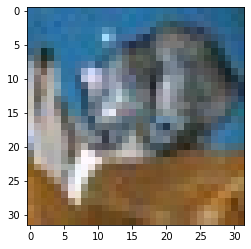

In [64]:
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

CLASSES=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Note: change the `ig_response` variable below if you didn't deploy an IG model
for prediction in response.predictions:
    label_index = np.argmax(prediction)
    class_name = CLASSES[label_index]
    confidence_score = prediction[label_index]
    print('Predicted class: ' + class_name + '\n' + 'Confidence score: ' + str(confidence_score))

    image = base64.b64decode(b64str)
    image = BytesIO(image)
    img = mpimg.imread(image, format='JPG')

    plt.imshow(img, interpolation='nearest')
    plt.show()

### Visualize the images with AI Explanations

The images returned show the explanations for only the top class predicted by the model. This means that if one of the model's predictions is incorrect, the pixels you see highlighted are for the *incorrect class*. For example, if the model predicted "airplane" when it should have predicted "cat", you can see explanations for why the model classified this image as an airplane.

If you deployed an Integrated Gradients model, you can visualize its feature attributions. Currently, the highlighted pixels returned from AI Explanations show the top 60% of pixels that contributed to the model's prediction. The pixels you see after running the cell below show the pixels that most signaled the model's prediction.

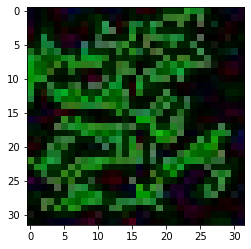

In [65]:
import io

for explanation in response.explanations:
    attributions = dict(explanation.attributions[0].feature_attributions)
    label_index = explanation.attributions[0].output_index[0]
    class_name = CLASSES[label_index]
    b64str = attributions['image']['b64_jpeg']
    image = base64.b64decode(b64str)
    image = io.BytesIO(image)
    img = mpimg.imread(image, format='JPG')

    plt.imshow(img, interpolation='nearest')
    plt.show()

## Undeploy the model

Let's now undeploy your model from the serving endpoint. Use this helper function `undeploy_model`, which takes the parameters:

- `deployed_model_id`: The model deployment identifier returned by the endpoint service when the model was deployed.
- `endpoint`: The AI Platform (Unified) fully qualified identifier for the endpoint where the model is deployed.

This function uses the endpoint client service and calls the method `undeploy_model`, with the parameters:

- `deployed_model_id`: The model deployment identifier returned by the endpoint service when the model was deployed.
- `endpoint`: The AI Platform (Unified) fully qualified identifier for the endpoint where the model is deployed.
- `traffic_split`: How to split traffic among the remaining deployed models on the endpoint.

Since this is the only deployed model on the endpoint, you simply can leave `traffic_split` empty by setting it to {}.

In [ ]:
def undeploy_model(deployed_model_id, endpoint):
    response = clients['endpoint'].undeploy_model(endpoint=endpoint, deployed_model_id=deployed_model_id, traffic_split={})
    print(response)


undeploy_model(deployed_model_id, endpoint_name)

# Cleaning up

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Dataset
- Model
- Endpoint
- Cloud Storage Bucket

In [ ]:
delete_dataset = True
delete_model = True
delete_endpoint = True
delete_bucket = True

# Delete the dataset using the AI Platform (Unified) fully qualified identifier for the dataset
try:
    if delete_dataset:
        clients['dataset'].delete_dataset(name=dataset['name'])
except Exception as e:
    print(e)

# Delete the model using the AI Platform (Unified) fully qualified identifier for the model
try:
    if delete_model:
        clients['model'].delete_model(name=model_to_deploy_name)
except Exception as e:
    print(e)

# Delete the endpoint using the AI Platform (Unified) fully qualified identifier for the endpoint
try:
    if delete_endpoint:
        clients['endpoint'].delete_endpoint(name=endpoint_name)
except Exception as e:
    print(e)

if delete_bucket and 'BUCKET_NAME' in globals():
    ! gsutil rm -r gs://$BUCKET_NAME
        
# Collect any unclaimed memory
import gc
gc.collect()